In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgbm
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from joblib import dump, load

# Get Data

In [2]:
train = pd.read_csv("Data/train.csv", index_col = 0)
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [3]:
X = train.drop("claim", axis = 1).copy()
y = train.claim.copy()

In [4]:
y.value_counts(normalize = True)

0    0.501508
1    0.498492
Name: claim, dtype: float64

In [5]:
test_data = pd.read_csv("Data/test.csv", index_col = 0)
sample_submission = pd.read_csv("Data/sample_solution.csv", index_col = 0)

# Train and test default LightGBM model

In [12]:
model = lgbm.LGBMClassifier(objective="binary")
cross_validation_score = cross_validate(model, X, y, scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                        return_train_score = True, return_estimator = True)

In [15]:
print("Mean AUC on training set:", np.mean(cross_validation_score['train_score']))
print("Mean AUC on test set:", np.mean(cross_validation_score['test_score']))

Mean AUC on training set: 0.8072918495282868
Mean AUC on test set: 0.8015118188492816


In [22]:
# Train on the whole training set and get predictions on the test set
model = lgbm.LGBMClassifier(objective="binary")
model.fit(X, y)
dump(model, 'Models/default_lgbm_model.joblib') 

In [25]:
y_pred = model.predict_proba(test_data)
sample_submission.claim = y_pred[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model.csv")

# Add Feature including number of nans per sample

In [6]:
def feature_generation(data):

    # add feature with number of na's per row + standard deviation
    features = [col for col in data.columns if 'f' in col] # if 'f' is in the name
    data['count_na'] = data[features].isna().sum(axis=1)

    features += ['count_na']

    # now do imputation with mean
    data[features] = data[features].fillna(data[features].mean())

    return data

In [7]:
X_w_nan = feature_generation(X)
test_data_w_nan = feature_generation(test_data)

In [28]:
model = lgbm.LGBMClassifier(objective="binary")
model.fit(X_w_nan, y)
dump(model, 'Models/default_lgbm_model_w_nan_count.joblib') 

['Models/default_lgbm_model_w_nan_count.joblib']

In [29]:
y_pred = model.predict_proba(test_data_w_nan)
sample_submission.claim = y_pred[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model_w_nan_count.csv")

Text(0.5, 1.0, 'Top 20 most important features')

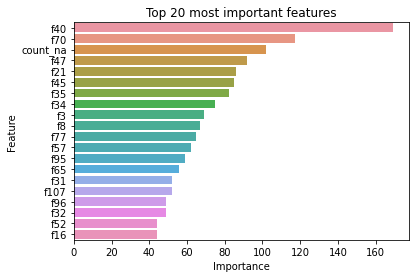

In [38]:
feature_importance = pd.DataFrame(columns = ["Feature", "Importance"])
feature_importance.Feature = X_w_nan.columns
feature_importance.Importance = model.feature_importances_
feature_importance = feature_importance.sort_values("Importance", ascending = False)

_ = sns.barplot(data = feature_importance.iloc[:20], x = 'Importance', y = 'Feature')
plt.title("Top 20 most important features")

# Hyperparameter Tuning using Optuna

In [36]:
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def objective(trial, X, y):
    param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 10, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    #cv_scores = np.empty(5)
    #for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    model = lgbm.LGBMClassifier(objective="binary", **param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        callbacks=[
            LightGBMPruningCallback(trial, "auc")
        ],  # Add a pruning callback
        verbose = 0
    )
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)

In [60]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_w_nan, y)
study.optimize(func, n_trials=100)

[I 2021-09-06 21:17:08,144] A new study created in memory with name: LGBM Classifier
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.388143647346598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.388143647346598
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:18:32,555] Trial 0 finished with value: 0.8113996388870579 and parameters: {'device_type': 'gpu', 'n_estimators': 8104, 'learning_rate': 0.22174988849545918, 'num_leaves': 640, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 30, 'lambda_l2': 45, 'min_gain_to_split': 1.388143647346598, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.8113996388870579.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=13.427340657971683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.427340657971683
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:19:43,266] Trial 1 finished with value: 0.81285649206763 and parameters: {'device_type': 'gpu', 'n_estimators': 3593, 'learning_rate': 0.17950083022824376, 'num_leaves': 780, 'max_depth': 4, 'min_data_in_leaf': 6200, 'lambda_l1': 55, 'lambda_l2': 95, 'min_gain_to_split': 13.427340657971683, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.81285649206763.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=9.63926253529289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.63926253529289
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:25:21,261] Trial 2 finished with value: 0.814700103069542 and parameters: {'device_type': 'gpu', 'n_estimators': 6056, 'learning_rate': 0.024461690456875167, 'num_leaves': 660, 'max_depth': 9, 'min_data_in_leaf': 4500, 'lambda_l1': 20, 'lambda_l2': 70, 'min_gain_to_split': 9.63926253529289, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 2 with value: 0.814700103069542.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=1.7012774867877583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7012774867877583
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:26:13,790] Trial 3 finished with value: 0.8122665597037276 and parameters: {'device_type': 'gpu', 'n_estimators': 1113, 'learning_rate': 0.29412384700686495, 'num_leaves': 1940, 'max_depth': 7, 'min_data_in_leaf': 6900, 'lambda_l1': 60, 'lambda_l2': 35, 'min_gain_to_split': 1.7012774867877583, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 2 with value: 0.814700103069542.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=2.3054702348989986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3054702348989986
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:29:56,220] Trial 4 finished with value: 0.8157751717240578 and parameters: {'device_type': 'gpu', 'n_estimators': 4152, 'learning_rate': 0.11776671664903711, 'num_leaves': 380, 'max_depth': 3, 'min_data_in_leaf': 5300, 'lambda_l1': 40, 'lambda_l2': 15, 'min_gain_to_split': 2.3054702348989986, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 4 with value: 0.8157751717240578.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=7.716581110347113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.716581110347113
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:30:02,256] Trial 5 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:31:13,575] Trial 6 pruned. Trial was pruned at iteration 789.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:31:20,685] Trial 7 pruned. Trial was pruned at iteration 4.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.107433876728523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.107433876728523
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:35:04,783] Trial 16 finished with value: 0.8149095445220149 and parameters: {'device_type': 'gpu', 'n_estimators': 4805, 'learning_rate': 0.16140036138623354, 'num_leaves': 2420, 'max_depth': 6, 'min_data_in_leaf': 8200, 'lambda_l1': 0, 'lambda_l2': 15, 'min_gain_to_split': 0.107433876728523, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.815832506134456.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=6.336056411717001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.336056411717001
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:35:10,288] Trial 17 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:37:18,237] Trial 18 finished with value: 0.815191645998086 and parameters: {'device_type': 'gpu', 'n_estimators': 2836, 'learning_rate': 0.1427204106398938, 'num_leaves': 1100, 'max_depth': 7, 'min_data_in_leaf': 3400, 'lambda_l1': 25, 'lambda_l2': 35, 'min_gain_to_split': 2.9446295690195643, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.815832506134456.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=6.818011942670447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.818011942670447
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:37:24,157] Trial 19 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:37:31,006] Trial 20 pruned. Trial was pruned at iteration 4.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:39:37,313] Trial 21 finished with value: 0.8153437855288277 and parameters: {'device_type': 'gpu', 'n_estimators': 2755, 'learning_rate': 0.146984008573427, 'num_leaves': 1100, 'max_depth': 7, 'min_data_in_leaf': 3300, 'lambda_l1': 25, 'lambda_l2': 30, 'min_gain_to_split':

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=2.3013438656703116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3013438656703116
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:39:43,081] Trial 22 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:39:49,037] Trial 23 pruned. Trial was pruned at iteration 4.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:39:54,808] Trial 24 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divis

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.560070934964443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.560070934964443
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:43:39,280] Trial 31 finished with value: 0.8156427436204344 and parameters: {'device_type': 'gpu', 'n_estimators': 9661, 'learning_rate': 0.1867732589399323, 'num_leaves': 760, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 8.560070934964443, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 30 with value: 0.8163029465509793.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.399358631397114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.399358631397114
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:43:45,492] Trial 32 pruned. Trial was pruned at iteration 5.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:44:43,261] Trial 33 finished with value: 0.8153766548140962 and parameters: {'device_type': 'gpu', 'n_estimators': 8917, 'learning_rate': 0.20681582688815145, 'num_leaves': 360, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 10, 'lambda_l2': 25, 'min_gain_to_split': 5.553449200942615, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 30 with value: 0.8163029465509793.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range i

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=14.889880072641052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.889880072641052
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:44:48,780] Trial 34 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:44:54,248] Trial 35 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:45:00,425] Trial 36 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divis

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.6054294706946717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6054294706946717
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-06 21:48:22,771] Trial 52 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:48:28,328] Trial 53 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-06 21:48:34,256] Trial 54 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divis

In [61]:
print(f"\tBest value (AUC): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (AUC): 0.81630
	Best params:
		device_type: gpu
		n_estimators: 9590
		learning_rate: 0.18227838793671425
		num_leaves: 760
		max_depth: 5
		min_data_in_leaf: 700
		lambda_l1: 10
		lambda_l2: 25
		min_gain_to_split: 5.782744082905875
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.9


In [ ]:
param_grid = {
        "device_type": 'gpu',
        "n_estimators": 9590,
        "learning_rate": 0.18227838793671425,
        "num_leaves": 760,
        "max_depth": 5,
        "min_data_in_leaf": 700,
        "lambda_l1": 10,
        "lambda_l2": 25,
        "min_gain_to_split": 5.782744082905875,
        "bagging_fraction": 0.6,
        "bagging_freq": 1,
        "feature_fraction": 0.9
    }


In [62]:
# Train model with best hyperparameters
model = lgbm.LGBMClassifier(objective="binary")
model.set_params(**study.best_params)
model.fit(X_w_nan, y)
dump(model, 'Models/default_lgbm_model_w_nan_count_tuned2.joblib') 

['Models/default_lgbm_model_w_nan_count_tuned2.joblib']

In [63]:
y_pred = model.predict_proba(test_data_w_nan)
sample_submission.claim = y_pred[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model_w_nan_count_tuned2.csv")

Text(0.5, 1.0, 'Top 20 most important features')

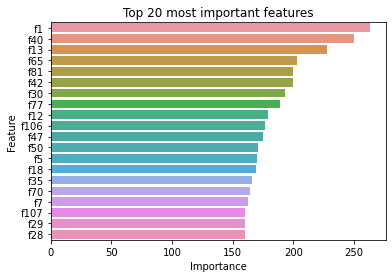

In [64]:
feature_importance = pd.DataFrame(columns = ["Feature", "Importance"])
feature_importance.Feature = X_w_nan.columns
feature_importance.Importance = model.feature_importances_
feature_importance = feature_importance.sort_values("Importance", ascending = False)

_ = sns.barplot(data = feature_importance.iloc[:20], x = 'Importance', y = 'Feature')
plt.title("Top 20 most important features")

Text(0.5, 1.0, 'Top 20 most important features')

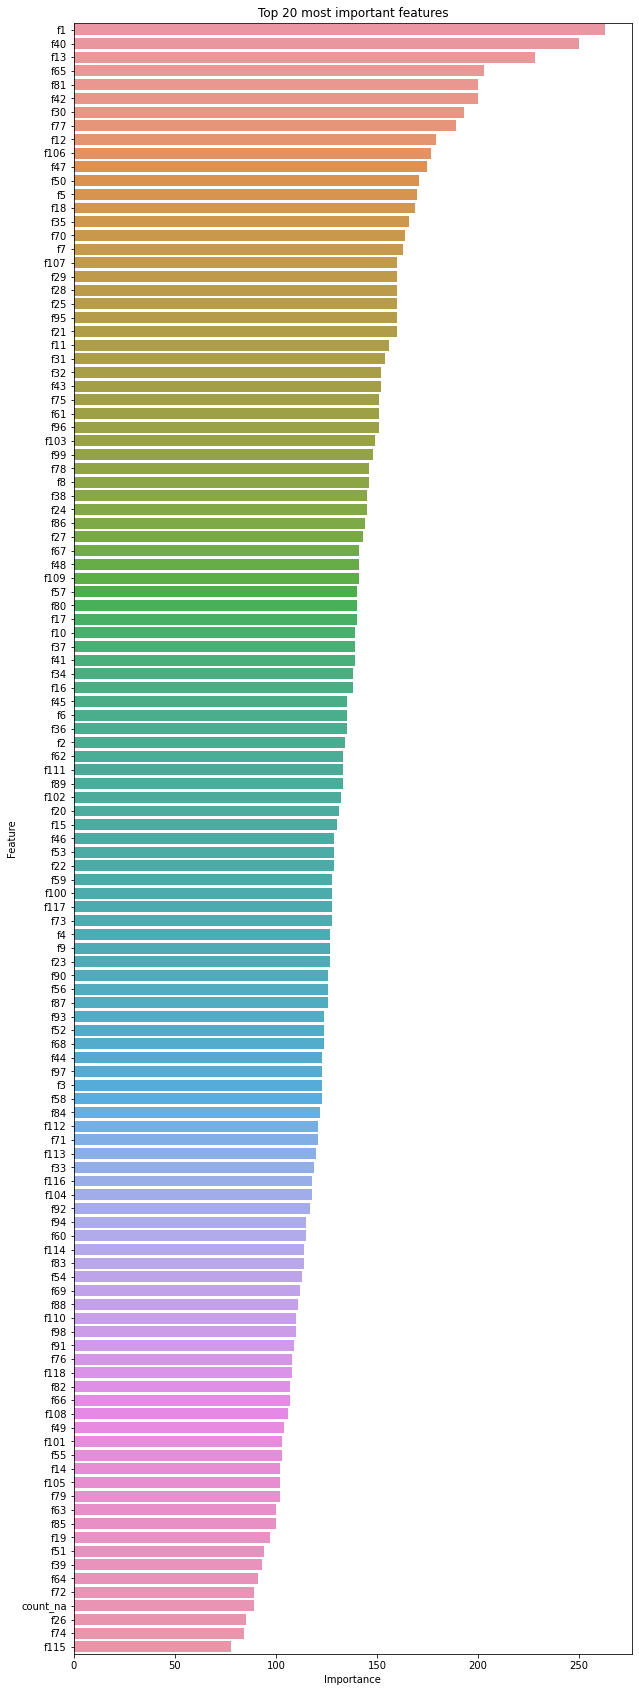

In [72]:
feature_importance = pd.DataFrame(columns = ["Feature", "Importance"])
feature_importance.Feature = X_w_nan.columns
feature_importance.Importance = model.feature_importances_
feature_importance = feature_importance.sort_values("Importance", ascending = False)

plt.figure(figsize=(10, 30))
_ = sns.barplot(data = feature_importance, x = 'Importance', y = 'Feature')
plt.title("Top 20 most important features")

# Pseudo-labeling with threshold 0.9

In [23]:
# Select the samples in the test set that were predicted with >= 0.9 probability 

high_probability_test_samples = test_data_w_nan.copy()
high_probability_test_samples["claim"] = y_pred.argmax(axis = 1)
high_probability_test_samples = high_probability_test_samples[y_pred.max(axis = 1) >= 0.9]
high_probability_test_samples.shape

(36095, 120)

In [26]:
X_w_nan_w_pseudo_labels = pd.concat([X_w_nan, high_probability_test_samples.drop("claim", axis = 1)])
X_w_nan_w_pseudo_labels.shape

(994014, 119)

In [27]:
y_w_pseudo_labels = pd.concat([y, high_probability_test_samples.claim.copy()])
y_w_pseudo_labels.shape

(994014,)

In [28]:
# Train model with best hyperparameters
model_w_pseudo_labels = lgbm.LGBMClassifier(objective="binary")
model_w_pseudo_labels.set_params(**{
        "device_type": 'gpu',
        "n_estimators": 9590,
        "learning_rate": 0.18227838793671425,
        "num_leaves": 760,
        "max_depth": 5,
        "min_data_in_leaf": 700,
        "lambda_l1": 10,
        "lambda_l2": 25,
        "min_gain_to_split": 5.782744082905875,
        "bagging_fraction": 0.6,
        "bagging_freq": 1,
        "feature_fraction": 0.9
    })
model_w_pseudo_labels.fit(X_w_nan_w_pseudo_labels, y_w_pseudo_labels)
dump(model, 'Models/default_lgbm_model_w_nan_count_tuned2_w_pseudo_labels.joblib') 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.782744082905875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.782744082905875
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


['Models/default_lgbm_model_w_nan_count_tuned2_w_pseudo_labels.joblib']

In [29]:
y_pred_w_pseudo_labels = model.predict_proba(test_data_w_nan)
sample_submission.claim = y_pred_w_pseudo_labels[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model_w_nan_count_tuned2_w_pseudo_labels.csv")

# Pseudo-labeling with full test data

In [30]:
# Select the samples in the test set that were predicted with >= 0.9 probability 

test_w_pseudo_labels = test_data_w_nan.copy()
test_w_pseudo_labels["claim"] = y_pred.argmax(axis = 1)
test_w_pseudo_labels.shape

(493474, 120)

In [31]:
X_w_nan_w_pseudo_labels = pd.concat([X_w_nan, test_w_pseudo_labels.drop("claim", axis = 1)])
X_w_nan_w_pseudo_labels.shape

(1451393, 119)

In [32]:
y_w_pseudo_labels = pd.concat([y, test_w_pseudo_labels.claim.copy()])
y_w_pseudo_labels.shape

(1451393,)

In [33]:
# Train model with best hyperparameters
model_w_pseudo_labels = lgbm.LGBMClassifier(objective="binary")
model_w_pseudo_labels.set_params(**{
        "device_type": 'gpu',
        "n_estimators": 9590,
        "learning_rate": 0.18227838793671425,
        "num_leaves": 760,
        "max_depth": 5,
        "min_data_in_leaf": 700,
        "lambda_l1": 10,
        "lambda_l2": 25,
        "min_gain_to_split": 5.782744082905875,
        "bagging_fraction": 0.6,
        "bagging_freq": 1,
        "feature_fraction": 0.9
    })
model_w_pseudo_labels.fit(X_w_nan_w_pseudo_labels, y_w_pseudo_labels)
dump(model, 'Models/default_lgbm_model_w_nan_count_tuned2_w_full_pseudo_labels.joblib') 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.782744082905875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.782744082905875
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


['Models/default_lgbm_model_w_nan_count_tuned2_w_full_pseudo_labels.joblib']

In [34]:
y_pred_w_pseudo_labels = model.predict_proba(test_data_w_nan)
sample_submission.claim = y_pred_w_pseudo_labels[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model_w_nan_count_tuned2_w_full_pseudo_labels.csv")

## Tuning

In [37]:
study_w_pseudo_labels = optuna.create_study(direction="maximize", study_name="LGBM Classifier With Pseudo Labels")
func = lambda trial: objective(trial, X_w_nan_w_pseudo_labels, y_w_pseudo_labels)
study_w_pseudo_labels.optimize(func, n_trials=100)

[I 2021-09-07 10:35:28,840] A new study created in memory with name: LGBM Classifier With Pseudo Labels
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.5967197060865406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5967197060865406
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:41:24,265] Trial 0 finished with value: 0.8848968874995462 and parameters: {'device_type': 'gpu', 'n_estimators': 1323, 'learning_rate': 0.030254835153624253, 'num_leaves': 2480, 'max_depth': 11, 'min_data_in_leaf': 7000, 'lambda_l1': 75, 'lambda_l2': 85, 'min_gain_to_split': 3.5967197060865406, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.8848968874995462.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0130888126684912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0130888126684912
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:45:28,045] Trial 1 finished with value: 0.9003586379085589 and parameters: {'device_type': 'gpu', 'n_estimators': 7821, 'learning_rate': 0.18864858489704292, 'num_leaves': 960, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 80, 'lambda_l2': 30, 'min_gain_to_split': 1.0130888126684912, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.9003586379085589.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=13.512267306896002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.512267306896002
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:47:49,487] Trial 2 finished with value: 0.8888062561465925 and parameters: {'device_type': 'gpu', 'n_estimators': 1410, 'learning_rate': 0.200855253001689, 'num_leaves': 1360, 'max_depth': 8, 'min_data_in_leaf': 9100, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 13.512267306896002, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.9003586379085589.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=9.3240366819004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.3240366819004
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:51:37,007] Trial 3 finished with value: 0.8941904947932087 and parameters: {'device_type': 'gpu', 'n_estimators': 9581, 'learning_rate': 0.25227978174368076, 'num_leaves': 1060, 'max_depth': 7, 'min_data_in_leaf': 7800, 'lambda_l1': 70, 'lambda_l2': 95, 'min_gain_to_split': 9.3240366819004, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.9003586379085589.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.675798078385106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.675798078385106
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:56:46,568] Trial 4 finished with value: 0.8998934555285254 and parameters: {'device_type': 'gpu', 'n_estimators': 9274, 'learning_rate': 0.2680073432615731, 'num_leaves': 2900, 'max_depth': 10, 'min_data_in_leaf': 300, 'lambda_l1': 80, 'lambda_l2': 65, 'min_gain_to_split': 4.675798078385106, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.9003586379085589.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=4.469789138129333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.469789138129333
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 10:56:55,444] Trial 5 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 10:57:08,430] Trial 6 pruned. Trial was pruned at iteration 14.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 10:57:28,736] Trial 7 pruned. Trial was pruned at iteration 63.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=9.335282396148635, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.335282396148635
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 11:32:44,259] Trial 9 pruned. Trial was pruned at iteration 11.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 11:33:46,404] Trial 10 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 11:34:13,607] Trial 11 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divis

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.235808680431187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.235808680431187
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 11:38:04,763] Trial 14 pruned. Trial was pruned at iteration 47.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 11:38:15,622] Trial 15 pruned. Trial was pruned at iteration 10.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 11:38:29,136] Trial 16 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not div

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3782486556411526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3782486556411526
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 12:00:46,087] Trial 33 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 12:00:54,440] Trial 34 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 12:01:02,426] Trial 35 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divis

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.298779799724488, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.298779799724488
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 12:09:03,701] Trial 43 pruned. Trial was pruned at iteration 25.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 12:09:13,249] Trial 44 pruned. Trial was pruned at iteration 4.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 12:09:20,695] Trial 45 pruned. Trial was pruned at iteration 0.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.752116387567169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.752116387567169
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-07 12:30:25,508] Trial 98 pruned. Trial was pruned at iteration 1.
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-09-07 12:36:51,208] Trial 99 finished with value: 0.9005760827946852 and parameters: {'device_type': 'gpu', 'n_estimators': 6245, 'learning_rate': 0.23652487183805918, 'num_leaves': 700, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 15, 'lambda_l2': 50, 'min_gain_to_split': 5.178653152737601, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 97 with value: 0.9007919455536919.


In [39]:
print(f"\tBest value (AUC): {study_w_pseudo_labels.best_value:.5f}")
print(f"\tBest params:")
study_w_pseudo_labels.best_params

	Best value (AUC): 0.90079
	Best params:


{'device_type': 'gpu',
 'n_estimators': 6785,
 'learning_rate': 0.2619688498533325,
 'num_leaves': 720,
 'max_depth': 8,
 'min_data_in_leaf': 1100,
 'lambda_l1': 15,
 'lambda_l2': 50,
 'min_gain_to_split': 4.629578709064481,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.8}

In [40]:
# Train model with best hyperparameters
model_w_pseudo_labels = lgbm.LGBMClassifier(objective="binary")
model_w_pseudo_labels.set_params(**{'device_type': 'gpu',
 'n_estimators': 6785,
 'learning_rate': 0.2619688498533325,
 'num_leaves': 720,
 'max_depth': 8,
 'min_data_in_leaf': 1100,
 'lambda_l1': 15,
 'lambda_l2': 50,
 'min_gain_to_split': 4.629578709064481,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.8})
model_w_pseudo_labels.fit(X_w_nan_wpip install jupyterlab_pseudo_labels, y_w_pseudo_labels)
dump(model, 'Models/default_lgbm_model_w_nan_count_w_full_pseudo_labels_tuned.joblib') 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.629578709064481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.629578709064481
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


['Models/default_lgbm_model_w_nan_count_w_full_pseudo_labels_tuned.joblib']

In [41]:
y_pred_w_pseudo_labels = model.predict_proba(test_data_w_nan)
sample_submission.claim = y_pred_w_pseudo_labels[:, 1]
sample_submission.to_csv("Submissions/default_lgbm_model_w_nan_count_w_full_pseudo_labels_tuned.csv")